Setup and EDA

Dataset link: https://www.kaggle.com/datasets/mikoajkoek/traffic-road-object-detection-polish-12k/code

In [1]:
! /Users/cara/anaconda3/envs/tf_env/bin/python -m pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 11.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 12.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 7.9 MB/s eta 0:00:00


In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from collections import Counter
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import shutil

%matplotlib inline



In [2]:
# Update this to your data root
root_dir = "Road_Detection_Data/road_detection/road_detection"
splits = ['train', 'valid', 'test']

In [3]:
print("Dataset Overview:")
for split in splits:
    img_dir = os.path.join(root_dir, split, "images")
    label_dir = os.path.join(root_dir, split, "labels")

    num_images = len([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
    num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    print(f"{split.upper()} → Images: {num_images}, Labels: {num_labels}")


Dataset Overview:
TRAIN → Images: 3534, Labels: 3534
VALID → Images: 327, Labels: 935
TEST → Images: 166, Labels: 484


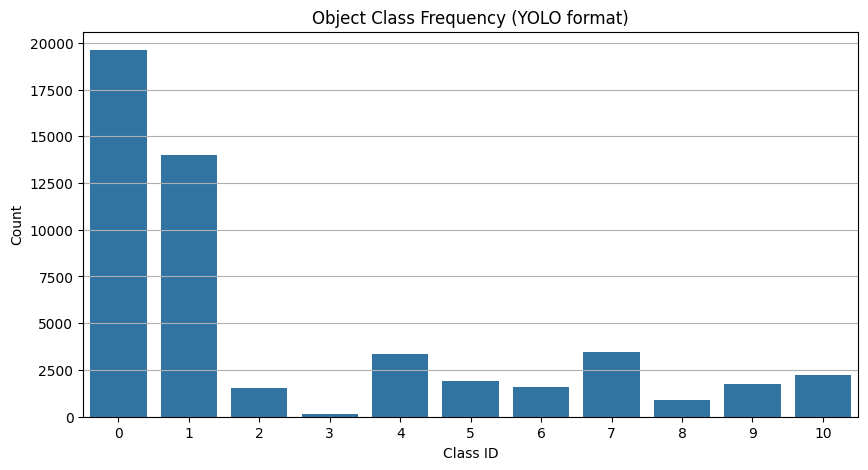

In [4]:
all_classes = []

for split in splits:
    label_dir = os.path.join(root_dir, split, "labels")
    for file in os.listdir(label_dir):
        if file.endswith('.txt'):
            with open(os.path.join(label_dir, file), 'r') as f:
                for line in f:
                    class_id = line.strip().split()[0]
                    all_classes.append(class_id)

class_counts = Counter(all_classes)
class_counts = {int(k): v for k, v in class_counts.items()}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Object Class Frequency (YOLO format)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.show()


Show Sample Image with Bounding Boxes (PIL)

In [5]:
def show_yolo_labels_with_pil(image_path, label_path, class_names=None):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    w, h = image.size

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            cls_id = int(parts[0])
            x_center, y_center, box_width, box_height = map(float, parts[1:])

            x1 = (x_center - box_width / 2) * w
            y1 = (y_center - box_height / 2) * h
            x2 = (x_center + box_width / 2) * w
            y2 = (y_center + box_height / 2) * h

            draw.rectangle([x1, y1, x2, y2], outline='lime', width=2)
            label = class_names[cls_id] if class_names and cls_id < len(class_names) else str(cls_id)
            draw.text((x1 + 2, y1 - 10), label, fill='red')

    # Use the filename in the title
    filename = os.path.basename(image_path)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{filename} — Sample Image with Bounding Boxes (YOLO + PIL)", fontsize=14)
    plt.show()



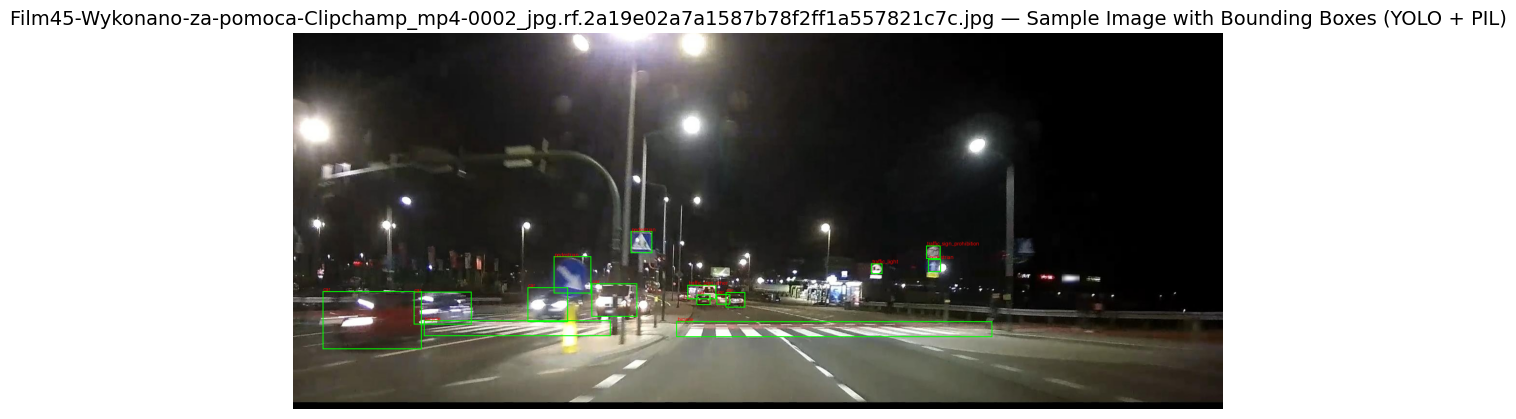

In [6]:
# Update these to your folder structure
img_dir = "Road_Detection_Data/road_detection/road_detection/train/images"
label_dir = "Road_Detection_Data/road_detection/road_detection/train/labels"

# Pick a sample image file (with long names)
sample_img_file = os.listdir(img_dir)[0]  # you can change the index to try others
sample_img_path = os.path.join(img_dir, sample_img_file)
sample_label_path = os.path.join(label_dir, sample_img_file.replace('.jpg', '.txt'))

# Define class names if you know them (update the order to match your dataset)
class_names = [
    "car", "pedestrian", "truck", "bus", "motorcycle", "bicycle",
    "traffic_light", "traffic_sign_warning", "traffic_sign_prohibition",
    "traffic_sign_other", "animal", "barrier", "background"
]

# Call the function to display image + boxes
show_yolo_labels_with_pil(sample_img_path, sample_label_path, class_names)


Image Size Distribution: Analyzing the image size distribution helps ensure consistent preprocessing for model training. It reveals whether resizing or padding is necessary and helps identify any outliers that could affect model performance. This step supports making informed decisions about how to standardize input dimensions for optimal accuracy and efficiency.

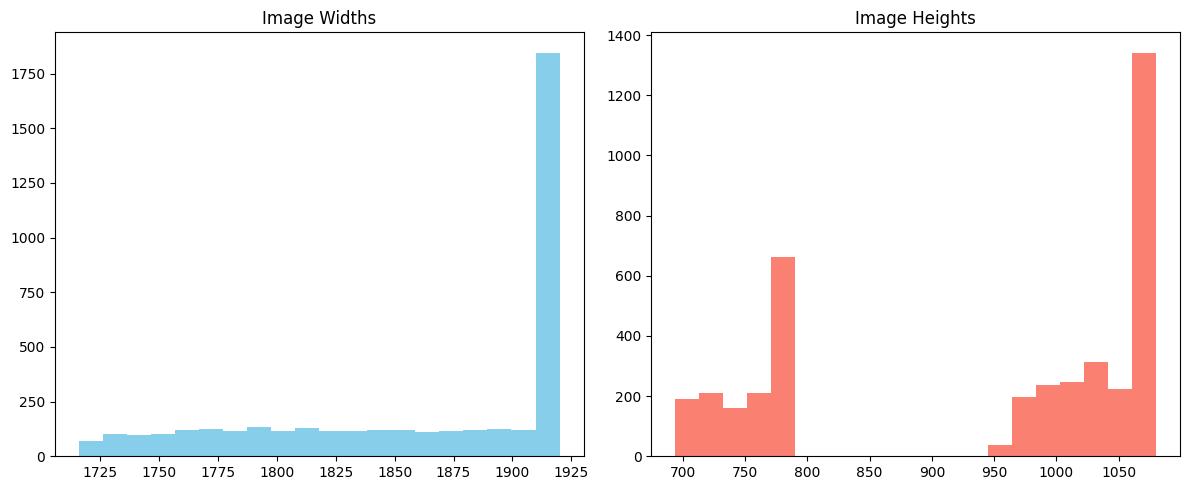

Min size: 1716x694
Max size: 1920x1080


In [7]:
widths, heights = [], []

for split in splits:
    img_dir = os.path.join(root_dir, split, "images")
    for file in os.listdir(img_dir):
        if file.endswith(".jpg"):
            with Image.open(os.path.join(img_dir, file)) as img:
                widths.append(img.width)
                heights.append(img.height)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color="skyblue")
plt.title("Image Widths")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color="salmon")
plt.title("Image Heights")

plt.tight_layout()
plt.show()

print(f"Min size: {min(widths)}x{min(heights)}")
print(f"Max size: {max(widths)}x{max(heights)}")


The majority of images in the dataset are close to 1920×1080 pixels, with a small number ranging down to 1716×694. This indicates that while most images are high-resolution and consistent in width, the height varies more significantly. To ensure uniform input for model training, resizing or padding will be necessary — ideally while preserving the aspect ratio to avoid distortion.

In [8]:
from PIL import Image

def resize_with_padding(image, target_size=(640, 640), fill_color=(0, 0, 0)):
    """
    Resize image to fit into target_size while maintaining aspect ratio.
    Pads the rest with fill_color (default: black).
    
    Args:
        image (PIL.Image): The input image.
        target_size (tuple): Desired (width, height)
        fill_color (tuple): Padding color (R, G, B)

    Returns:
        PIL.Image: The resized and padded image.
    """
    original_width, original_height = image.size
    target_width, target_height = target_size

    # Calculate scaling factor and new size
    scale = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # Resize image
    resized_image = image.resize((new_width, new_height), Image.BICUBIC)

    # Create a new blank image and paste resized into center
    new_image = Image.new("RGB", target_size, fill_color)
    top = (target_height - new_height) // 2
    left = (target_width - new_width) // 2
    new_image.paste(resized_image, (left, top))

    return new_image


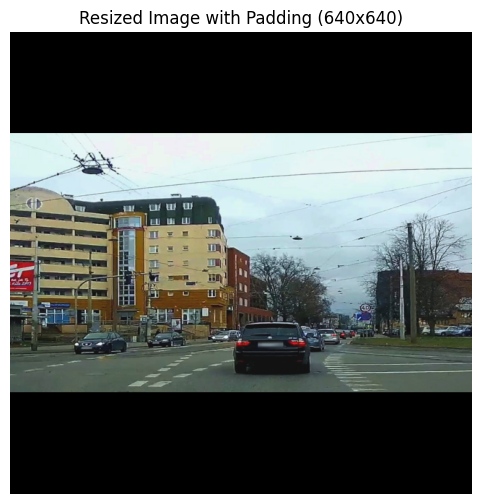

In [9]:
# Load image
img_path = "Road_Detection_Data/road_detection/road_detection/train/images/Film99-Wykonano-za-pomoca-Clipchamp_mp4-0011_jpg.rf.f04d795cdff577369d1fec158a883d8b_aug_out_1.png"
image = Image.open(img_path).convert("RGB")

# Resize with padding
resized = resize_with_padding(image, target_size=(640, 640))

# Show image inline using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(resized)
plt.axis('off')
plt.title("Resized Image with Padding (640x640)")
plt.show()

To ensure consistent input dimensions for model training, all images were resized to 640×640 while preserving their original aspect ratio. Padding was applied to prevent distortion, which is especially important for object detection tasks where object shapes and positions matter. This step standardizes the dataset for efficient and accurate model learning.

In [10]:
missing_anns, missing_imgs = [], []

for split in splits:
    img_dir = os.path.join(root_dir, split, "images")
    label_dir = os.path.join(root_dir, split, "labels")

    image_files = set([f.replace(".jpg", "") for f in os.listdir(img_dir) if f.endswith(".jpg")])
    label_files = set([f.replace(".txt", "") for f in os.listdir(label_dir) if f.endswith(".txt")])

    missing_img = label_files - image_files
    missing_ann = image_files - label_files

    missing_imgs += [f + ".txt" for f in missing_img]
    missing_anns += [f + ".jpg" for f in missing_ann]

print(f"Missing annotations for {len(missing_anns)} image(s).")
print(f"Missing images for {len(missing_imgs)} label(s).")


Missing annotations for 0 image(s).
Missing images for 926 label(s).


The dataset contains no missing annotations, meaning all images have corresponding label files. However, there are 7,866 label files with no matching images, likely due to leftover annotations from augmentation or partial deletions. These should be reviewed and removed to ensure consistency and avoid issues during training.

In [11]:
def remove_orphaned_labels(image_dir, label_dir, image_ext='.jpg', label_ext='.txt', delete=False):
    image_files = set(f.replace(image_ext, '') for f in os.listdir(image_dir) if f.endswith(image_ext))
    label_files = set(f.replace(label_ext, '') for f in os.listdir(label_dir) if f.endswith(label_ext))

    orphan_labels = label_files - image_files
    print(f"Found {len(orphan_labels)} label files with no corresponding image.")

    if delete:
        for label_id in orphan_labels:
            path_to_remove = os.path.join(label_dir, label_id + label_ext)
            os.remove(path_to_remove)
        print(f"✅ Deleted {len(orphan_labels)} orphaned label files.")
    else:
        print("🟡 Preview mode only — no files deleted. To remove them, set `delete=True`.")

    return orphan_labels


label_dir = "Road_Detection_Data/road_detection/road_detection/train/labels"
image_dir = "Road_Detection_Data/road_detection/road_detection/train/images"

# Preview orphaned label files (no deletion yet)
remove_orphaned_labels(image_dir, label_dir, delete=False)

# To actually delete them, run this:
remove_orphaned_labels(image_dir, label_dir, delete=True)


Found 0 label files with no corresponding image.
🟡 Preview mode only — no files deleted. To remove them, set `delete=True`.
Found 0 label files with no corresponding image.
✅ Deleted 0 orphaned label files.


set()

In [12]:
def check_missing_images_again(image_dir, label_dir, image_ext='.jpg', label_ext='.txt'):
    image_files = set(f.replace(image_ext, '') for f in os.listdir(image_dir) if f.endswith(image_ext))
    label_files = set(f.replace(label_ext, '') for f in os.listdir(label_dir) if f.endswith(label_ext))

    remaining_orphans = label_files - image_files

    print(f"🔍 Remaining orphaned label files: {len(remaining_orphans)}")
    if remaining_orphans:
        print("⚠️ Warning: Some orphaned labels still exist. Example:")
        print(list(remaining_orphans)[:10])  # Show a few examples
    else:
        print("✅ All orphaned label files have been successfully removed.")

# Run this after deletion
check_missing_images_again(image_dir, label_dir)


🔍 Remaining orphaned label files: 0
✅ All orphaned label files have been successfully removed.


The bar plot above shows the distribution of object classes in the training dataset. The training data is highly imbalanced, with 'car' and 'pedestrian' significantly more frequent than other classes. This imbalance could lead to poor generalization for rare classes such as 'traffic sign' or 'bicycle'. To address this, targeted data augmentation or class weighting strategies may be necessary during training.

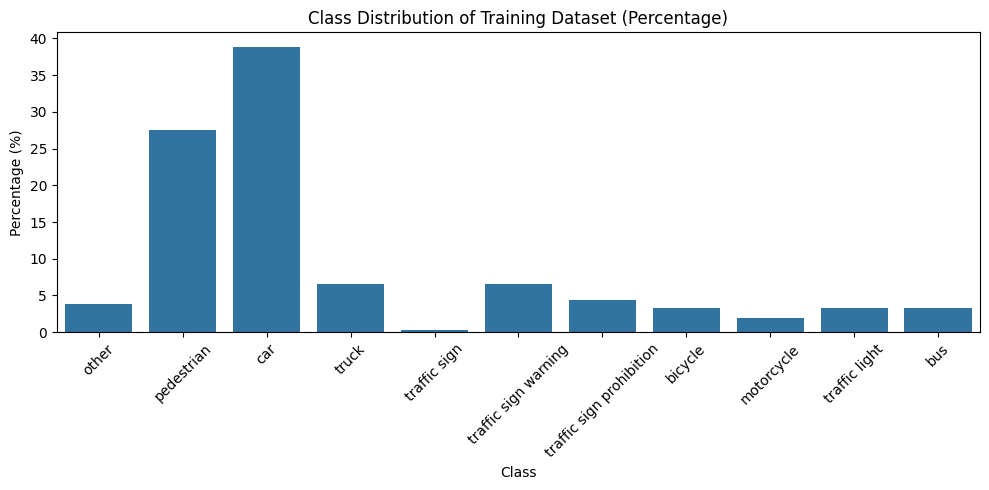

In [13]:

# Count classes from label files
def count_classes_from_labels(label_dir):
    class_counts = Counter()
    for fname in os.listdir(label_dir):
        if fname.endswith(".txt"):
            with open(os.path.join(label_dir, fname), 'r') as f:
                for line in f:
                    class_id = line.strip().split()[0]
                    class_counts[int(class_id)] += 1
    return class_counts

# Set the label folder path (train set)
label_dir = "Road_Detection_Data/road_detection/road_detection/train/labels"
class_counts = count_classes_from_labels(label_dir)

# Map class IDs to names
class_names = {
    0: "car",
    1: "pedestrian",
    2: "traffic light",
    3: "traffic sign",
    4: "truck",
    5: "other",
    6: "bus",
    7: "traffic sign warning",
    8: "motorcycle",
    9: "bicycle",
    10: "traffic sign prohibition"
}

# Convert to percentages
total = sum(class_counts.values())
labels = [class_names.get(cls, str(cls)) for cls in class_counts.keys()]
percentages = [round((count / total) * 100, 2) for count in class_counts.values()]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=percentages)
plt.xticks(rotation=45)
plt.ylabel("Percentage (%)")
plt.xlabel("Class")
plt.title("Class Distribution of Training Dataset (Percentage)")
plt.tight_layout()
plt.show()


The training dataset shows significant class imbalance, with 'car' and 'pedestrian' making up the majority of labeled objects. Less frequent classes like 'traffic sign' and 'bicycle' appear in very small proportions. This imbalance may lead to biased model performance, so strategies like class weighting or data augmentation should be considered during training.

In [14]:

# 1. Count class frequencies
def count_classes(label_dir):
    class_counts = Counter()
    for fname in os.listdir(label_dir):
        if fname.endswith(".txt"):
            with open(os.path.join(label_dir, fname), 'r') as f:
                for line in f:
                    cls_id = int(line.strip().split()[0])
                    class_counts[cls_id] += 1
    return class_counts

label_dir = "Road_Detection_Data/road_detection/road_detection/train/labels"
class_counts = count_classes(label_dir)

# 2. Compute total and number of classes
total_instances = sum(class_counts.values())
num_classes = max(class_counts.keys()) + 1

# 3. Calculate class weights (inverse frequency)
class_weights = {}
for cls in range(num_classes):
    count = class_counts.get(cls, 1)  # avoid division by zero
    class_weights[cls] = total_instances / (num_classes * count)

# 4. Show weights
for cls, weight in sorted(class_weights.items()):
    print(f"Class {cls}: Weight = {weight:.4f}")


Class 0: Weight = 0.2338
Class 1: Weight = 0.3301
Class 2: Weight = 2.7688
Class 3: Weight = 29.0726
Class 4: Weight = 1.3724
Class 5: Weight = 2.3522
Class 6: Weight = 2.8040
Class 7: Weight = 1.3833
Class 8: Weight = 4.8313
Class 9: Weight = 2.7144
Class 10: Weight = 2.0458
